## Image denoising using kernel PCA

In [ ]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.decomposition import PCA, KernelPCA



In [ ]:
# upload the data
X, y = fetch_openml(data_id=41082, as_frame=False, return_X_y=True)
X = MinMaxScaler().fit_transform(X)

In [ ]:
X

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        7.70361222e-03, 3.99508414e-04, 7.16501752e-06],
       [7.29775229e-05, 4.76844961e-03, 6.73844627e-02, ...,
        4.56048675e-01, 3.16044638e-01, 1.56683409e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        8.08172031e-03, 1.03491704e-04, 0.00000000e+00],
       ...,
       [1.49953814e-05, 1.09008138e-03, 2.25058739e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.10965823e-04, 2.29344721e-03, 2.50811796e-02, ...,
        1.17172704e-03, 5.78335990e-05, 2.38833917e-06],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.40025257e-06, 0.00000000e+00, 0.00000000e+00]])

In [ ]:
X.shape

(9298, 256)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=0, train_size=1_000, test_size=100
)

### Gaussian Noise:

Gaussian Noise is a statistical noise having a probability density function equal to normal distribution, also known as Gaussian Distribution. Random Gaussian function is added to Image function to generate this noise. It is also called as electronic noise because it arises in amplifiers or detectors.

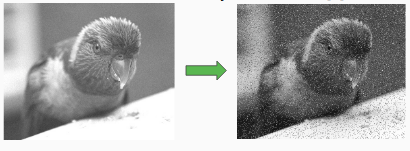


## What is meant by salt and pepper noise?
Salt and pepper noise refers to a wide variety of processes that result in the same basic image degradation: only a few pixels are noisy, but they are very noisy. The effect is similar to sprinkling white and black dots—salt and pepper—on the image.


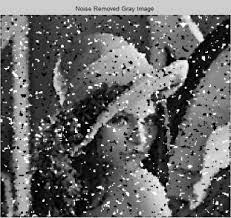

In [ ]:
import numpy as np
import os
import cv2
def noisy(noise_typ,image):
   if noise_typ == "gauss":
      row,col= image.shape
      mean = 0
      var = 0.1
      sigma = var**0.5
      gauss = np.random.normal(mean,sigma,(row,col))
      gauss = gauss.reshape(row,col)
      noisy = image + gauss
      return noisy
   elif noise_typ == "s&p":
      row,col= image.shape
      s_vs_p = 0.5
      amount = 0.004
      out = np.copy(image)
      # Salt mode
      num_salt = np.ceil(amount * image.size * s_vs_p)
      coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
      out[coords] = 1

      # Pepper mode
      num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
      coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
      out[coords] = 0
      return out

## using gaussian noise

In [ ]:
X_test_noisy = noisy("gauss",X_test)

In [ ]:
X_train_noisy = noisy("gauss",X_train)

In [ ]:
import matplotlib.pyplot as plt


def plot_digits(X, title):
    """Small helper function to plot 100 digits."""
    fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(8, 8))
    for img, ax in zip(X, axs.ravel()):
        ax.imshow(img.reshape((16, 16)), cmap="Greys")
        ax.axis("off")
    fig.suptitle(title, fontsize=24)

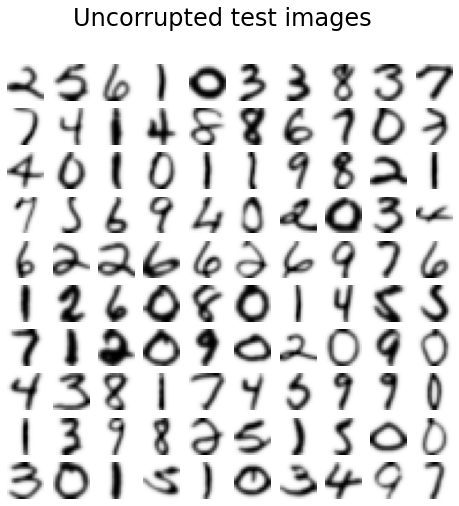

In [ ]:
# view the Uncorrupted test images
plot_digits(X_test, "Uncorrupted test images")

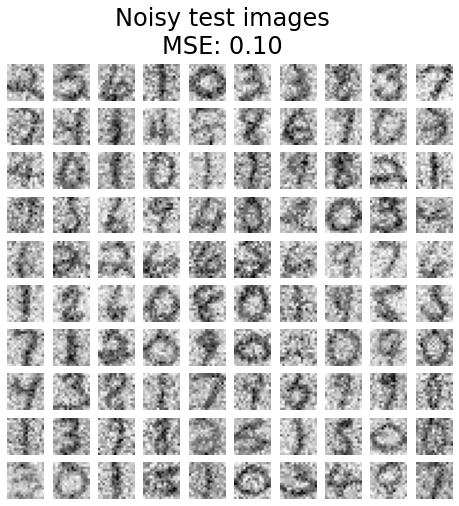

In [ ]:
# view the Noisy test images
plot_digits(X_test_noisy,
            f"Noisy test images\n"
            f"MSE: {np.mean((X_test - X_test_noisy) ** 2):.2f}")

Text(0, 0.5, 'cumulative explained variance')

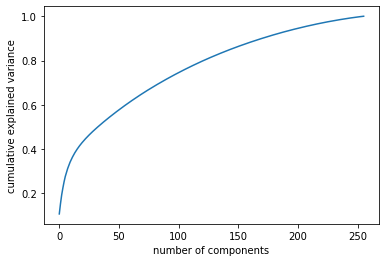

In [ ]:
# plot the number of required components against the level of impurity or noise.
pca = PCA().fit(X_train_noisy)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [ ]:
# using PCA 

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipe = Pipeline(steps=[('pca', pca)])

param_grid = {
    'pca__n_components': [12,32,52,72,100]
}
search = GridSearchCV(pipe, param_grid, n_jobs=-1)

In [ ]:
search.fit(X_train_noisy)
print(search.best_params_)

{'pca__n_components': 32}


In [ ]:
from sklearn.decomposition import PCA, KernelPCA

pca = PCA(n_components=32)
kernel_pca = KernelPCA(n_components=400, kernel="rbf", gamma=1e-3,
                       fit_inverse_transform=True, alpha=5e-3)

pca.fit(X_train_noisy)
_ = kernel_pca.fit(X_train_noisy)

In [ ]:
X_reconstructed_kernel_pca = kernel_pca.inverse_transform(
    kernel_pca.transform(X_test_noisy))
X_reconstructed_pca = pca.inverse_transform(pca.transform(X_test_noisy))

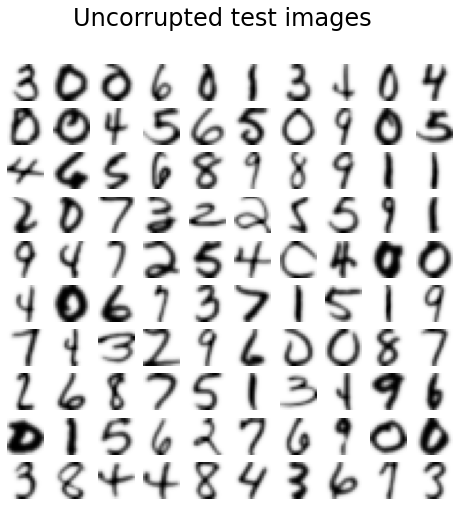

In [ ]:
plot_digits(X_train, "Uncorrupted test images")

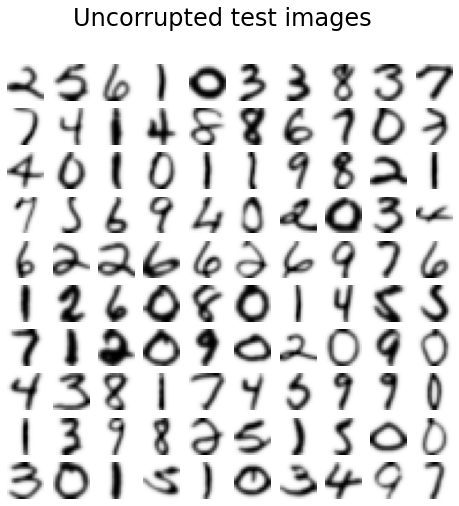

In [ ]:
plot_digits(X_test, "Uncorrupted test images")

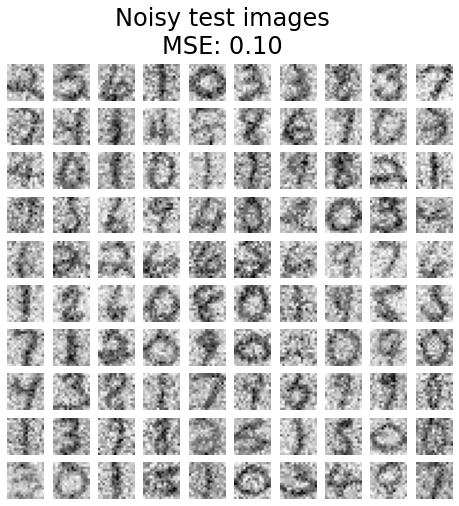

In [ ]:
# image before using PCA
plot_digits(X_test_noisy,
            f"Noisy test images\n"
            f"MSE: {np.mean((X_test - X_test_noisy) ** 2):.2f}")

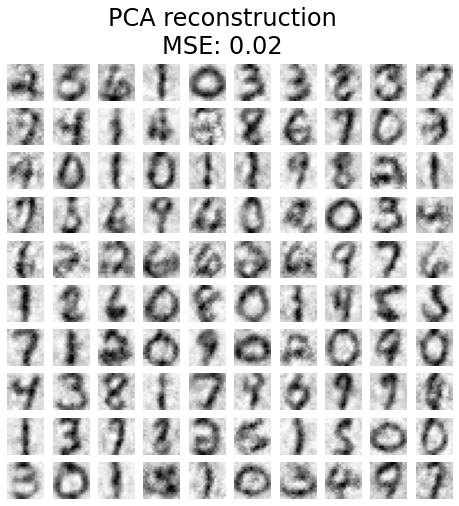

In [ ]:
# image after using PCA
plot_digits(X_reconstructed_pca,
            f"PCA reconstruction\n"
            f"MSE: {np.mean((X_test - X_reconstructed_pca) ** 2):.2f}")

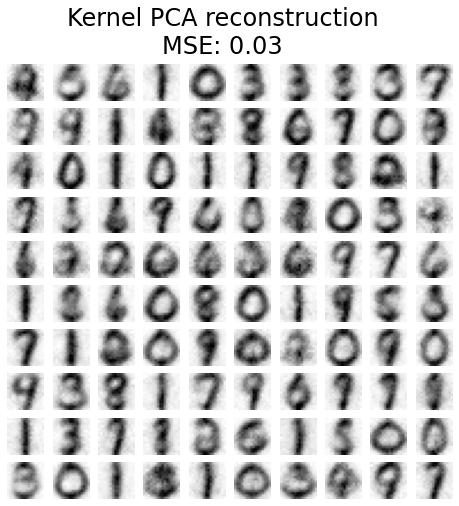

In [ ]:
# image before using kernel
plot_digits(X_reconstructed_kernel_pca,
            f"Kernel PCA reconstruction\n"
            f"MSE: {np.mean((X_test - X_reconstructed_kernel_pca) ** 2):.2f}")

### conclusions
PCA has a lower MSE than kernel PCA. However, the qualitative analysis might not favor PCA instead of kernel PCA. We observe that kernel PCA is able to remove background noise and provide a smoother image.

## using salt and pepper noise

In [ ]:
X_test_noisy = noisy("s&p",X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [ ]:
X_train_noisy = noisy("s&p",X_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


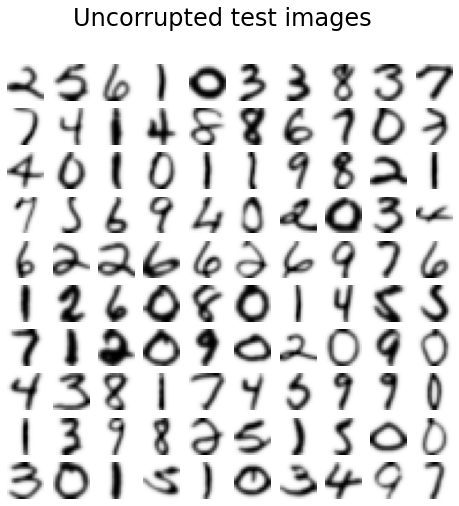

In [ ]:
plot_digits(X_test, "Uncorrupted test images")

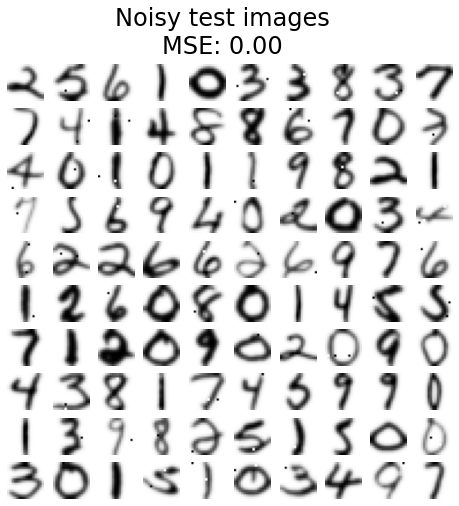

In [ ]:
plot_digits(X_test_noisy,
            f"Noisy test images\n"
            f"MSE: {np.mean((X_test - X_test_noisy) ** 2):.2f}")

Text(0, 0.5, 'cumulative explained variance')

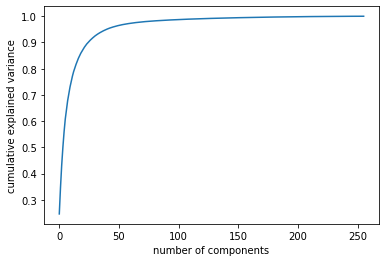

In [ ]:
pca = PCA().fit(X_train_noisy)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [ ]:
pipe = Pipeline(steps=[('pca', pca)])

param_grid = {
    'pca__n_components': [12,32,52,72,100]
}
search = GridSearchCV(pipe, param_grid, n_jobs=-1)

In [ ]:
search.fit(X_train_noisy)
print(search.best_params_)

{'pca__n_components': 72}


In [ ]:
pca = PCA(n_components=72)
kernel_pca = KernelPCA(n_components=300, kernel="rbf", gamma=1e-3,
                       fit_inverse_transform=True, alpha=5e-3)

pca.fit(X_train_noisy)
_ = kernel_pca.fit(X_train_noisy)

In [ ]:
X_reconstructed_kernel_pca = kernel_pca.inverse_transform(
    kernel_pca.transform(X_test_noisy))
X_reconstructed_pca = pca.inverse_transform(pca.transform(X_test_noisy))

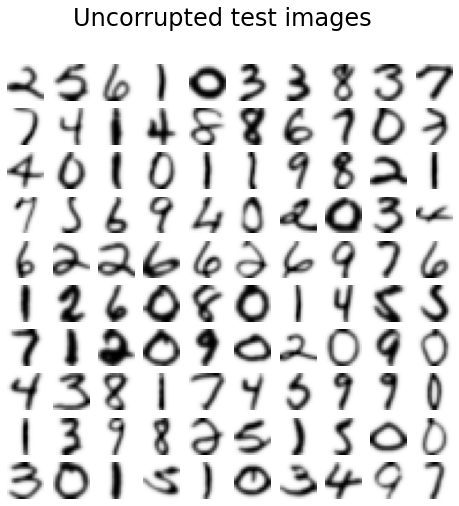

In [ ]:
plot_digits(X_test, "Uncorrupted test images")

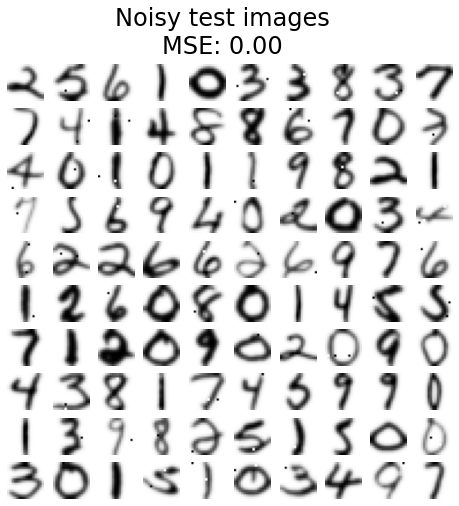

In [ ]:
plot_digits(X_test_noisy,
            f"Noisy test images\n"
            f"MSE: {np.mean((X_test - X_test_noisy) ** 2):.2f}")

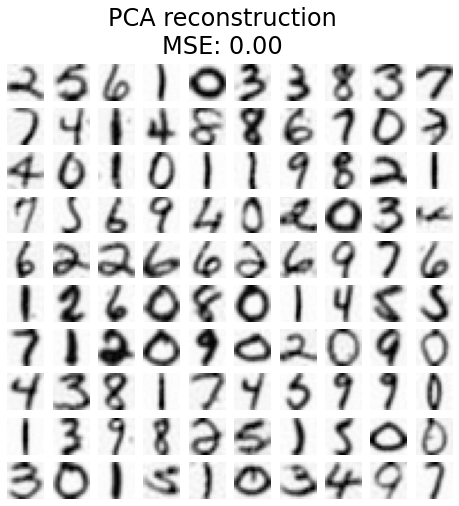

In [ ]:
plot_digits(X_reconstructed_pca,
            f"PCA reconstruction\n"
            f"MSE: {np.mean((X_test - X_reconstructed_pca) ** 2):.2f}")

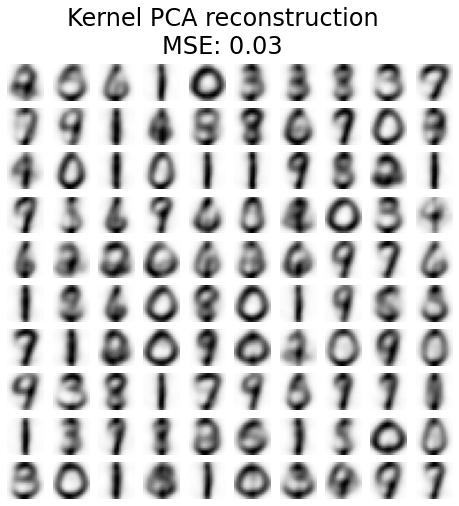

In [ ]:
plot_digits(X_reconstructed_kernel_pca,
            f"Kernel PCA reconstruction\n"
            f"MSE: {np.mean((X_test - X_reconstructed_kernel_pca) ** 2):.2f}")

PCA has a lower MSE than kernel PCA. and PCA removing the salt and pepper noise from the image.